## **Import required libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import time
from scipy.io import savemat, loadmat

## **Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True, timeout_ms=120000*5)

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/My Drive/Speech_Project/train_16k_standardisation.zip' -d '/content/Train'
!unzip -q '/content/drive/My Drive/Speech_Project/test_16k_standardisation.zip' -d '/content/Test'

In [ ]:
!mv /content/Train/train_normalised/train_input /content/Train/
!mv /content/Train/train_normalised/train_output /content/Train/
!rmdir /content/Train/train_normalised/

In [ ]:
!mv /content/Test/test_normalised/test_input /content/Test/
!mv /content/Test/test_normalised/test_output /content/Test/
!rmdir /content/Test/test_normalised/

In [ ]:
class my_Dataset(Dataset):
    # Characterizes a dataset for PyTorch
    def __init__(self, data_paths, target_paths, transform=None):
        self.data_paths = data_paths
        self.target_paths = target_paths
        self.transform = transform

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, index):
        x = torch.from_numpy(np.expand_dims(np.load(self.data_paths[index]),axis = 0))
        y = torch.from_numpy(np.expand_dims(np.load(self.target_paths[index]),axis = 0))
        if self.transform:
            x = self.transform(x)

        return x, y

root_train_input = '/content/Train/train_16k_standardisation/train_input/'
root_train_output = '/content/Train/train_16k_standardisation/train_output/' 
root_test_input = '/content/Test/test_16k_standardisation/test_input/'
root_test_output = '/content/Test/test_16k_standardisation/test_output/' 

train_input = sorted(os.listdir('/content/Train/train_16k_standardisation/train_input'))
train_output = sorted(os.listdir('/content/Train/train_16k_standardisation/train_output'))
test_input = sorted(os.listdir('/content/Test/test_16k_standardisation/test_input'))
test_output = sorted(os.listdir('/content/Test/test_16k_standardisation/test_output'))

train_input = list(map(root_train_input.__add__,train_input))
train_output = list(map(root_train_output.__add__,train_output))
test_input = list(map(root_test_input.__add__,test_input))
test_output = list(map(root_test_output.__add__,test_output))
print(len(train_output), len(train_input), len(test_output), len(test_input))

train_set = my_Dataset(train_input,train_output) 
test_dataset = my_Dataset(test_input,test_output)       

17554 17554 2819 2819


In [ ]:
generator=torch.Generator().manual_seed(123)
train_dataset, val_dataset = torch.utils.data.random_split(train_set, [round(train_set.__len__()*0.95),round(train_set.__len__()*0.05)],generator=generator)

In [ ]:
train_loader = DataLoader(train_dataset,batch_size=400)
val_loader = DataLoader(val_dataset,batch_size=400)
# test_loader = DataLoader(test_dataset,batch_size=200)

In [ ]:
a,b = next(iter(train_loader))

In [ ]:
a.shape, b.shape

(torch.Size([400, 1, 64, 64]), torch.Size([400, 1, 64, 64]))

## **Data Visualisation**

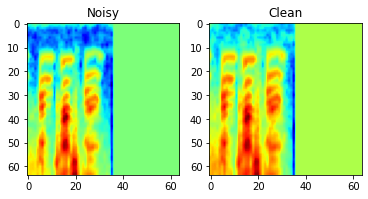

In [ ]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(a[9][0], cmap='jet')
axs[0].set_title('Noisy')
axs[1].imshow(b[9][0], cmap='jet')
axs[1].set_title('Clean')
plt.show()

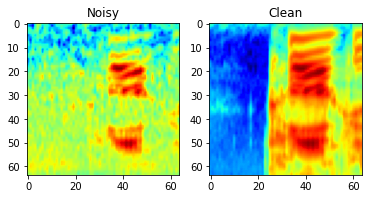

In [ ]:
a,b = next(iter(val_loader))
fig, axs = plt.subplots(1,2)
axs[0].imshow(a[1][0], cmap='jet')
axs[0].set_title('Noisy')
axs[1].imshow(b[1][0], cmap='jet')
axs[1].set_title('Clean')
plt.show()

### **Exploration of mask values**

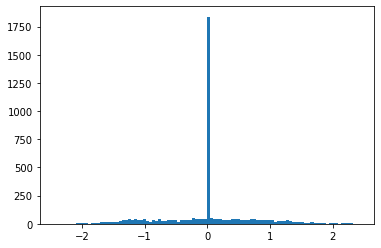

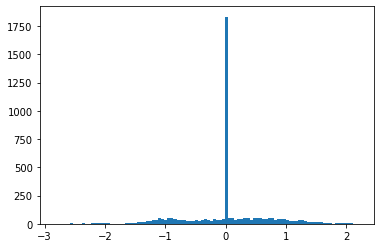

In [ ]:
i = 9
plt.hist(a[i][0].ravel(),bins = 100)
plt.show()

plt.hist(b[i][0].ravel(),bins = 100)
plt.show()

## **Architecture: Explicit CNN - GAN**

### **CNN-GAN**

#### **Generator**

In [ ]:
class Gen_TF(nn.Module):

    def __init__(self, kernel_size=4, stride=2, filter_size_1=64, filter_size_2=128, filter_size_3=256, filter_size_4=512, bottle_neck_size=100):
        super(Gen_TF, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.filter_size_1 = filter_size_1
        self.filter_size_2 = filter_size_2
        self.filter_size_3 = filter_size_3
        self.filter_size_4 = filter_size_4
        self.bottle_neck_size = bottle_neck_size

        self.conv2d_1 = nn.Conv2d(1, filter_size_1, kernel_size, stride)
        self.conv2d_2 = nn.Conv2d(filter_size_1, filter_size_2, kernel_size, stride)
        self.conv2d_3 = nn.Conv2d(filter_size_2, filter_size_3, kernel_size, stride)
        self.conv2d_4 = nn.Conv2d(filter_size_3, filter_size_4, kernel_size, stride)

        self.flatten = nn.Flatten()
        self.bottle_neck = nn.Linear(filter_size_4*2*2, bottle_neck_size)
        self.bn_to_deconv = nn.Linear(bottle_neck_size, filter_size_4*2*2)
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Tanh() # nn.Sigmoid()

        self.batchnorm_encoder1 = nn.BatchNorm2d(filter_size_1)
        self.batchnorm_encoder2 = nn.BatchNorm2d(filter_size_2)
        self.batchnorm_encoder3 = nn.BatchNorm2d(filter_size_3)
        self.batchnorm_encoder4 = nn.BatchNorm2d(filter_size_4)

        self.batchnorm_decoder4 = nn.BatchNorm2d(filter_size_3)
        self.batchnorm_decoder3 = nn.BatchNorm2d(filter_size_2)
        self.batchnorm_decoder2 = nn.BatchNorm2d(filter_size_1)
        self.batchnorm_decoder1 = nn.BatchNorm2d(1)

        self.deconv2d_4 = nn.ConvTranspose2d(filter_size_4, filter_size_3, kernel_size, stride)
        self.deconv2d_3 = nn.ConvTranspose2d(filter_size_3, filter_size_2, kernel_size, stride)
        self.deconv2d_2 = nn.ConvTranspose2d(filter_size_2, filter_size_1, kernel_size, stride, output_padding=1)
        self.deconv2d_1 = nn.ConvTranspose2d(filter_size_1, 1, kernel_size, stride)


    def forward(self, spectrogram):

        x = self.conv2d_1(spectrogram)
        x = self.batchnorm_encoder1(x)
        x = self.relu(x)

        x = self.conv2d_2(x)
        x = self.batchnorm_encoder2(x)
        x = self.relu(x)

        x = self.conv2d_3(x)
        x = self.batchnorm_encoder3(x)
        x = self.relu(x)

        x = self.conv2d_4(x)
        x = self.batchnorm_encoder4(x)
        x = self.relu(x)

        x = self.flatten(x)
        x = self.bottle_neck(x)
        x = self.bn_to_deconv(x)
        x = torch.reshape(x, (-1,512,2,2))

        x = self.deconv2d_4(x)
        x = self.batchnorm_decoder4(x)
        x = self.relu(x)

        x = self.deconv2d_3(x)
        x = self.batchnorm_decoder3(x)
        x = self.relu(x)

        x = self.deconv2d_2(x)
        x = self.batchnorm_decoder2(x)
        x = self.relu(x)

        x = self.deconv2d_1(x)

        # x = self.batchnorm_decoder1(x)
        # x = self.relu(x)

        # x = self.sigmoid(x)

        x = spectrogram * x

        return x

#### **Discriminator**

In [ ]:
class Dis_TF(nn.Module):

    def __init__(self, kernel_size=4, stride=2, filter_size_1=64, filter_size_2=128, filter_size_3=256, filter_size_4=512, filter_size_5=64, filter_size_6=1):
        super(Dis_TF, self).__init__()

        self.kernel_size = kernel_size
        self.stride = stride
        self.filter_size_1 = filter_size_1
        self.filter_size_2 = filter_size_2
        self.filter_size_3 = filter_size_3
        self.filter_size_4 = filter_size_4
        self.filter_size_5 = filter_size_5
        self.filter_size_6 = filter_size_6

        self.conv2d_1 = nn.Conv2d(1, filter_size_1, kernel_size, stride)
        self.conv2d_2 = nn.Conv2d(filter_size_1, filter_size_2, kernel_size, stride)
        self.conv2d_3 = nn.Conv2d(filter_size_2, filter_size_3, kernel_size, stride)
        self.conv2d_4 = nn.Conv2d(filter_size_3, filter_size_4, kernel_size, stride)
        self.conv2d_5 = nn.Conv2d(filter_size_4, filter_size_5, 1, 1)
        self.conv2d_6 = nn.Conv2d(filter_size_5, filter_size_6, 1, 1)

        self.flatten = nn.Flatten()
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

        self.batchnorm_encoder1 = nn.BatchNorm2d(filter_size_1)
        self.batchnorm_encoder2 = nn.BatchNorm2d(filter_size_2)
        self.batchnorm_encoder3 = nn.BatchNorm2d(filter_size_3)
        self.batchnorm_encoder4 = nn.BatchNorm2d(filter_size_4)
        self.batchnorm_encoder5 = nn.BatchNorm2d(filter_size_5)
        self.batchnorm_encoder6 = nn.BatchNorm2d(filter_size_6)

        self.dense = nn.Linear(filter_size_6 * 2 *2 , 1)

    def forward(self, spectrogram):

        x = self.conv2d_1(spectrogram)
        x = self.batchnorm_encoder1(x)
        x = self.relu(x)

        x = self.conv2d_2(x)
        x = self.batchnorm_encoder2(x)
        x = self.relu(x)

        x = self.conv2d_3(x)
        x = self.batchnorm_encoder3(x)
        x = self.relu(x)

        x = self.conv2d_4(x)
        x = self.batchnorm_encoder4(x)
        x = self.relu(x)

        x = self.conv2d_5(x)
        x = self.batchnorm_encoder5(x)
        x = self.relu(x)

        x = self.conv2d_6(x)

        x = self.flatten(x)
        # print(x.shape)
        x = self.dense(x)
        x = self.sigmoid(x)
        # print(type(x),x.shape)

        return x

In [ ]:
model = Dis_TF()
yhat = model(torch.zeros(1,1,64,64))

## **Training loop**

In [ ]:
# shape = (n, 1, 64, 64)
def train_GAN(train_loader,val_loader, n_epochs=20, lr=0.01):

    gen_tf = Gen_TF().cuda()
    gen_tf.double()
    params_gen = gen_tf.parameters()

    dis_tf = Dis_TF().cuda()
    dis_tf.double()
    params_dis = dis_tf.parameters()

    print('params calculated')

    opt_gen = optim.Adam(params_gen, lr=lr)
    opt_dis = optim.SGD(params_dis, lr=lr)

    criterion = nn.BCELoss() 

    running_loss = {'gen_train': [], 'gen_val': [], 'dis_train': [], 'dis_val':[]}

    print('loaded loss and opt')

    for i in range(n_epochs):

        # opt_gen.zero_grad()
        # opt_dis.zero_grad()

        epoch_loss_gen = 0
        epoch_loss_dis = 0
        val_loss_gen = 0
        val_loss_dis = 0
        
        for j, (batch_input,real_output) in enumerate(train_loader):

            start = time.time()

            # Dis loss
            dis_tf.zero_grad()
            dis_real = dis_tf(real_output.cuda()).view(-1)
            dis_loss_real = criterion(dis_real, torch.ones_like(dis_real))
            dis_loss_real.backward() 
            opt_dis.step()

            # update for fake samples
            dis_tf.zero_grad()
            fake_output = gen_tf(batch_input.cuda())
            dis_fake = dis_tf(fake_output.cuda()).view(-1)
            dis_loss_fake = criterion(dis_fake, torch.zeros_like(dis_fake))
            dis_loss_fake.backward()      
            opt_dis.step() 

            # Gen loss
            # fake_output = gen_tf(batch_input.cuda())
            gen_tf.zero_grad()
            dis_tf.zero_grad()
            gen_fake = gen_tf(batch_input.cuda())
            fake = dis_tf(gen_fake).view(-1)
            gen_loss = criterion(fake, torch.ones_like(fake)) + 0.5 * torch.mean((real_output.cuda() - gen_fake)**2)
            gen_loss.backward()
            opt_gen.step()

            epoch_loss_gen+=gen_loss.item()
            epoch_loss_dis = epoch_loss_dis + dis_loss_real.item() + dis_loss_fake.item()


            print(f"Epoch [{i}/{n_epochs}] Batch {j}/{len(train_loader)} Loss D_real: {dis_loss_real:.4f}, Loss D_fake: {dis_loss_fake:.4f}, loss G: {gen_loss:.4f}, Time taken: {time.time()-start:.4f}" )

            del batch_input, real_output

        print('\n\n Epoch ',i,' : Train D Loss = ', epoch_loss_dis/len(train_loader), 
              ' : Train G Loss = ', epoch_loss_gen/len(train_loader))
        
        running_loss['dis_train'].append(epoch_loss_dis/len(train_loader))
        running_loss['gen_train'].append(epoch_loss_gen/len(train_loader))
        
        for j, (val_input, real_output) in enumerate(val_loader):

            start = time.time()

            fake_output = gen_tf(val_input.cuda())
            dis_real = dis_tf(real_output.cuda()).view(-1)
            dis_fake = dis_tf(fake_output.cuda()).view(-1)
            # Dis loss
            dis_loss_real = criterion(dis_real, torch.ones_like(dis_real))
            dis_loss_fake = criterion(dis_fake, torch.zeros_like(dis_fake))
            
            dis_loss = (dis_loss_real + dis_loss_fake)

            # Gen loss
            fake = dis_tf(fake_output.cuda()).view(-1)
            gen_loss_1 = criterion(fake, torch.ones_like(fake))
            gen_loss_2 = 0.5 * torch.mean((real_output.cuda() - fake_output)**2) # this was implemented in the repo
            gen_loss = gen_loss_1 + gen_loss_2

            val_loss_gen+=gen_loss.item()
            val_loss_dis+=dis_loss.item()

            print(f"Epoch [{i}/{n_epochs}] Batch {j}/{len(val_loader)} Loss D_real: {dis_loss:.4f}, loss G: {gen_loss:.4f}, Time taken: {time.time()-start:.4f}" )


            del val_input, real_output

        print('             Val D Loss = ',val_loss_dis/len(val_loader),' : Val G Loss = ', val_loss_gen/len(val_loader))
        running_loss['dis_val'].append(val_loss_dis/len(val_loader))
        running_loss['gen_val'].append(val_loss_gen/len(val_loader))
         
        # Save model state after each epoch
        state = {'D model': dis_tf,
                 'G model': gen_tf,
                 'D opt': opt_dis,
                 'G opt':opt_gen}

        filename = '/content/drive/My Drive/Speech_Project/explicit_GAN_weights/checkpoint_gan_normalised_epoch_'+str(i)+'.pth.tar'
        torch.save(state, filename)
        torch.cuda.empty_cache()
        
        print('             Checkpointed model state')

    return running_loss


In [ ]:
train_loader = DataLoader(train_dataset,batch_size=200)
val_loader = DataLoader(val_dataset,batch_size=200)

In [ ]:
running_loss = train_GAN(train_loader,val_loader, n_epochs=10, lr=0.002) 

params calculated
loaded loss and opt
Epoch [0/10] Batch 0/192 Loss D_real: 0.4919, Loss D_fake: 0.9599, loss G: 1.8083, Time taken: 4.2523
Epoch [0/10] Batch 1/192 Loss D_real: 0.4894, Loss D_fake: 0.9241, loss G: 1.9095, Time taken: 3.9556
Epoch [0/10] Batch 2/192 Loss D_real: 0.4814, Loss D_fake: 0.9372, loss G: 0.9431, Time taken: 3.9690
Epoch [0/10] Batch 3/192 Loss D_real: 0.4873, Loss D_fake: 0.9421, loss G: 0.8093, Time taken: 3.9851
Epoch [0/10] Batch 4/192 Loss D_real: 0.4831, Loss D_fake: 0.9572, loss G: 0.7501, Time taken: 3.9743
Epoch [0/10] Batch 5/192 Loss D_real: 0.4762, Loss D_fake: 0.9790, loss G: 0.7078, Time taken: 3.9695
Epoch [0/10] Batch 6/192 Loss D_real: 0.4773, Loss D_fake: 0.9563, loss G: 0.7509, Time taken: 3.9848
Epoch [0/10] Batch 7/192 Loss D_real: 0.4816, Loss D_fake: 0.9655, loss G: 0.6912, Time taken: 3.9938
Epoch [0/10] Batch 8/192 Loss D_real: 0.4669, Loss D_fake: 0.9537, loss G: 0.6841, Time taken: 4.0041
Epoch [0/10] Batch 9/192 Loss D_real: 0.4698

### **Loss curves**

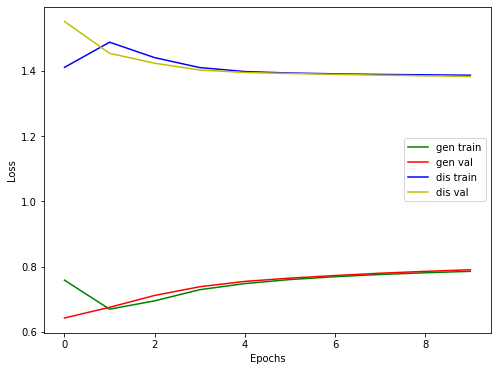

In [ ]:
num_epochs = range(0,len(running_loss['gen_train']))

plt.figure(figsize = (8,6))
plt.plot(num_epochs, running_loss['gen_train'],'g')
plt.plot(num_epochs, running_loss['gen_val'],'r')
plt.plot(num_epochs, running_loss['dis_train'],'b')
plt.plot(num_epochs, running_loss['dis_val'],'y')

plt.legend(['gen train', 'gen val','dis train','dis val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## **Predictions on train and val set**

In [ ]:
a,b = next(iter(train_loader))
pred = gen_tf(a.cuda()).detach().cpu().numpy()

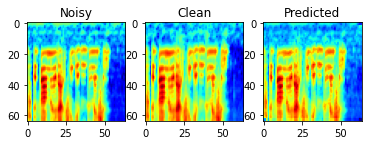

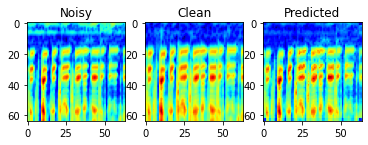

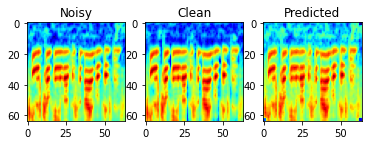

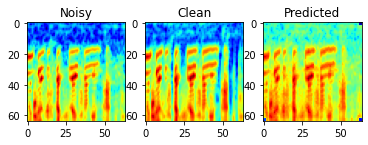

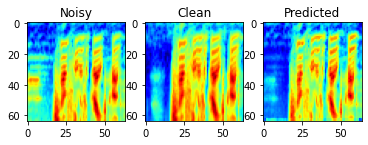

In [ ]:
xxx = [10,20,30,50,100]
for xx in xxx:
  fig, axs = plt.subplots(1,3)
  axs[0].imshow(a[xx][0], cmap='jet')
  axs[0].set_title('Noisy')
  axs[1].imshow(b[xx][0], cmap='jet')
  axs[1].set_title('Clean')
  axs[2].imshow(pred[xx][0], cmap='jet')
  axs[2].set_title('Predicted')
  plt.show()

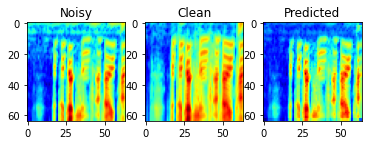

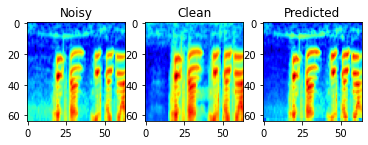

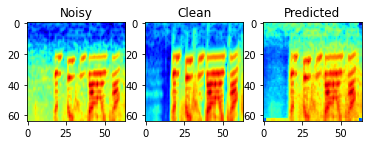

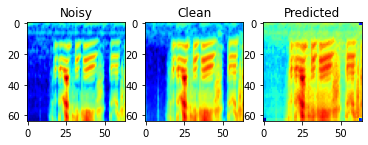

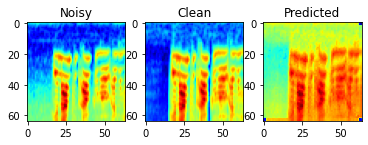

In [ ]:
a,b = next(iter(val_loader))
pred = gen_tf(a.cuda()).detach().cpu().numpy()

xxx = [10,20,30,50,100]
for xx in xxx:
  fig, axs = plt.subplots(1,3)
  axs[0].imshow(a[xx][0], cmap='jet')
  axs[0].set_title('Noisy')
  axs[1].imshow(b[xx][0], cmap='jet')
  axs[1].set_title('Clean')
  axs[2].imshow(pred[xx][0], cmap='jet')
  axs[2].set_title('Predicted')
  plt.show()

## **Evaluation on testing set**

In [ ]:
test_loader = DataLoader(test_dataset,batch_size=200)

In [ ]:
criterion = nn.MSELoss() 
loss = 0
predicted = []
for j, (batch_input,batch_output) in enumerate(test_loader):
    model_output = gen_tf(batch_input.cuda())
    loss += criterion(model_output,batch_output.cuda()).item()
    predicted.append(model_output.detach().cpu().numpy())
print('Model output testset loss = ', loss/len(test_loader))

Model output testset loss =  0.011128418251779598


In [ ]:
a,b = next(iter(test_loader))
c = gen_tf(a.cuda()).detach().cpu().numpy()
xx = [10,20,30,40,100]
for xxx in xx:
  fig, axs = plt.subplots(1,3)
  axs[0].imshow(a[xxx][0], cmap='jet')
  axs[0].set_title('Noisy')
  axs[1].imshow(b[xxx][0], cmap='jet')
  axs[1].set_title('Clean')
  axs[2].imshow(c[xxx][0], cmap='jet')
  axs[2].set_title('Predicted')
  plt.show()

In [ ]:
# root = '/content/Test/test_16k_standardisation_zeroPadded/test_input/'
root = '/content/Test/test_16k_standardisation/test_input/'
os.mkdir('/content/predicted/')
save_root = '/content/predicted/'
test_files = os.listdir(root)
audios = []
for name in test_files:
    audio = '_'.join(name.split('_')[:3])
    if audio not in audios:
      audios.append(audio)

In [ ]:
for i,name in enumerate(audios):
  input_files = sorted(list(filter(lambda x: x.startswith(name + "_") , test_files)))
  positions = np.argsort([int(x.split('.')[0].split('_')[-1])-1 for x in input_files])
  #ordered_files = input_files[positions]
  
  input_arr = []
  for filename in input_files:
    x = np.expand_dims(np.load(root+filename),axis = 0)
    input_arr.append(x)
  model_input = torch.from_numpy(np.array(input_arr))
  model_output = gen_tf(model_input.cuda()).detach().cpu().numpy()
  # model_output = torch.div(gen_tf(model_input.cuda()).detach().cpu(), model_input).numpy()

  arranged_out = model_output[positions]
  concat_out = np.concatenate((arranged_out), axis = 2)

  savemat( save_root+name+'.mat', mdict = {'PRED_SPEC': concat_out[0]})

In [ ]:
!zip -q -r GAN_explicit_16k_latest.zip 'predicted'

In [ ]:
!cp '/content/GAN_explicit_16k_latest.zip' '/content/drive/My Drive/Speech_Project/Latest_Results/'